#### Investigate dual TCR's and TRB sister chains


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cd ..

/home/romi/projects/cvc


In [7]:
import os, sys
import collections
import importlib
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import ast

import anndata as ad
import scanpy as sc

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)

from cvc import model_utils
from cvc import plot_utils
from cvc import utils
from single_cell_research import cvc_sequencing as cs
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

#### Load data

In [20]:
data_dir = DATA_DIR + "tra_to_trb_mapping_100k_scData.csv"#"public_private_scData_100k.csv"#"10x_nsclc_tra_trb_df.csv"

In [21]:
# load data db
embed_data = pd.read_csv(data_dir, engine="pyarrow")

In [22]:
# edit data
embed_data.rename(columns={'cdr3': 'Sequences'}, inplace=True) # rename column to "Sequences"
embed_data.TRB = embed_data.TRB.apply(ast.literal_eval) # convert string to list
embed_data['num_unique_trbs'] = embed_data.TRB.apply(lambda y: len(set(y))) # count unique TRB's
embed_data = embed_data.sort_values(by='num_unique_trbs', ascending=False).reset_index(drop=True) # sort by num unique TRB's
embed_data['num_tra_appearances'] = embed_data.TRA.apply(ast.literal_eval).apply(len) # count TRA appearances

In [23]:
embed_data

TRA_unique  \
0       1131    CAVMDSNYQLIW   
1       2221    CAVSGSQGNLIF   
2       2214    CALNPRGNKLTF   
3       2212    CGTDANTDKLIF   
4        303    CAVRDSNYQLIW   
...      ...             ...   
27966  24375  CAVVRGSTLGRLYF   
27967   5051   CALSRSNTGKLIF   
27968  17534  CIVRGTNTGNQFYF   
27969  25579  CAASASGANSKLTF   
27970   7815   CERSWNQGGKLIF   

                                                     TRA  \
0      [4753925880108738616, 7354672065897563514, -44...   
1      [2010364308877174869, -5059521981789630672, 71...   
2      [-5168857178549002523, -4069685209219304367, -...   
3      [-5168857178549002523, -7212231281204103109, -...   
4      [7777393511859566687, 3293535638874374359, 594...   
...                                                  ...   
27966                              [2084267729292082475]   
27967                              [-397675657753646188]   
27968                             [-1153793260651713641]   
27969                             [-6564679558912181084]   
27970                             [-8073719545693390868]   

                                                     TRB  num_unique_trbs  \
0      [CATSRDRGGTDTQYF, CASSPLRVSGANVLTF, CSARLADYEQ...               90   
1      [CSALAEYYNEQFF, CASSLFQSLAATYNEQFF, CASSLGAGIA...               81   
2      [CASSLFQSLAATYNEQFF, CASSPRQELIYEQYF, CSVLSDSY...               72   
3      [CASSLFQSLAATYNEQFF, CASSPRQELIYEQYF, CSVLSDSY...               72   
4      [CASSQDRDFPTYEQYF, CASSDGRGGADTQYF, CASSGDNTGE...               67   
...                                                  ...              ...   
27966                                                 []                0   
27967                                                 []                0   
27968                                                 []                0   
27969                                                 []                0   
27970                                                 []                0   

       num_tra_appearances  
0                      102  
1                       89  
2                       65  
3                       90  
4                       89  
...                    ...  
27966                    1  
27967                    1  
27968                    1  
27969                    1  
27970                    1  

[27971 rows x 6 columns]

In [24]:
# params
chosen_idx = 1
# specific TRA sequence to plot
tra_2plot = embed_data.iloc[chosen_idx].TRA_unique
# TRB sequences to mark (of the chosen TRA)
trbs_to_mark = embed_data.iloc[chosen_idx].TRB
print("num unique trbs for chosen tra: ", len(set(trbs_to_mark)))

num unique trbs for chosen tra:  81


In [25]:
tra_2plot

'CAVSGSQGNLIF'

In [26]:
# output TRB's to df
csv_name = "./CDR3_data/TRA_specific/trbs_of_" + tra_2plot + "_df.csv"
trbs_of_tra_df = pd.DataFrame({'Sequences': trbs_to_mark})
trbs_of_tra_df.to_csv(csv_name)

In [27]:
# create list of all TRB's
TRB_list = []
for index, row in embed_data.iterrows():
    for TRB in row['TRB']:
        TRB_list.append(TRB)

In [28]:
# take related TRB's to the given TRA
def create_tra_specific_df(tra_seq, return_trb=True):
    # Assuming that tra_df is your dataframe containing the TRA and TRB sequences
    tra_unique = tra_seq
    # Filter the rows of tra_df corresponding to the TRA unique sequence
    tra_rows = embed_data.loc[embed_data['TRA_unique'] == tra_unique]
    # Extract the list of TRB sequences
    trb_list = tra_rows['TRB'].values[0]
    trb_list = trb_list
    if return_trb:
        return trb_list
    trb_list.append(tra_unique)
    df_tra_specific = pd.DataFrame({'Sequences': [tra_unique] + trb_list,
                                    'chain': ['TRA'] + ['TRB'] * len(trb_list)})
    return df_tra_specific

In [29]:
all_seqs = list(set(TRB_list))
specific_seqs = list(set(create_tra_specific_df(tra_2plot, return_trb=True)))

# remove specific TRB's
general_seqs = list(set(all_seqs) - set(specific_seqs))
tags = ["general" if seq in general_seqs else "TRA-specific" for seq in all_seqs]

TRB_df = pd.DataFrame({'Sequences': all_seqs, 'Label': tags})

In [35]:
TRB_df.to_csv("./CDR3_data/TRA_specific/labeled_all_trbs_by_" + tra_2plot + ".csv")

#### Create and Display embeddings

In [56]:
# read TRA-specific TRB's that were labeled with public/private
TRB_public_private = pd.read_csv("./CDR3_data/TRA_specific/labeled_specific_trbs_by_CAVSGSQGNLIF_embeddings_pub_priv.csv")

In [57]:
# update label column
TRB_df['Label'] = TRB_public_private['Label']

In [58]:
collections.Counter(TRB_df['Label'])

Counter({'General': 27771,
         'Private_TRA-specific': 21,
         'Public_TRA-specific': 60})

In [59]:
df_for_embedding = TRB_df
TRANSFORMER_TO_USE = TRANSFORMER

from cvc.embbeding_wrapper import EmbeddingWrapper

# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER_TO_USE, DEVICE, df_for_embedding, batch_size=128, method="mean", layers=[-1], pbar=True, max_len=120)
embed_wrap.embeddings.shape

Some weights of the model checkpoint at /home/romi/projects/cvc/output_5mil_even_priv_pub were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/218 [00:00<?, ?it/s]

(27852, 768)

In [60]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata(n_comps=50)

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


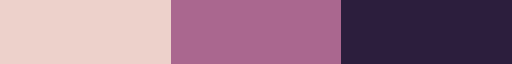

In [64]:
# Create colormap of 16 shades of blues
num_colors = len(collections.Counter(TRB_df['Label']))
color_map = ListedColormap(sns.cubehelix_palette(num_colors))
# color_map = ListedColormap(sns.husl_palette(num_colors))
color_map

In [33]:
embed_wrap.sequences_df['Label'] = 'general'
embed_wrap.sequences_df.loc[
    embed_wrap.sequences_df['Sequences'].isin(trbs_to_mark), 'Label'] = 'TRA-specific'

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


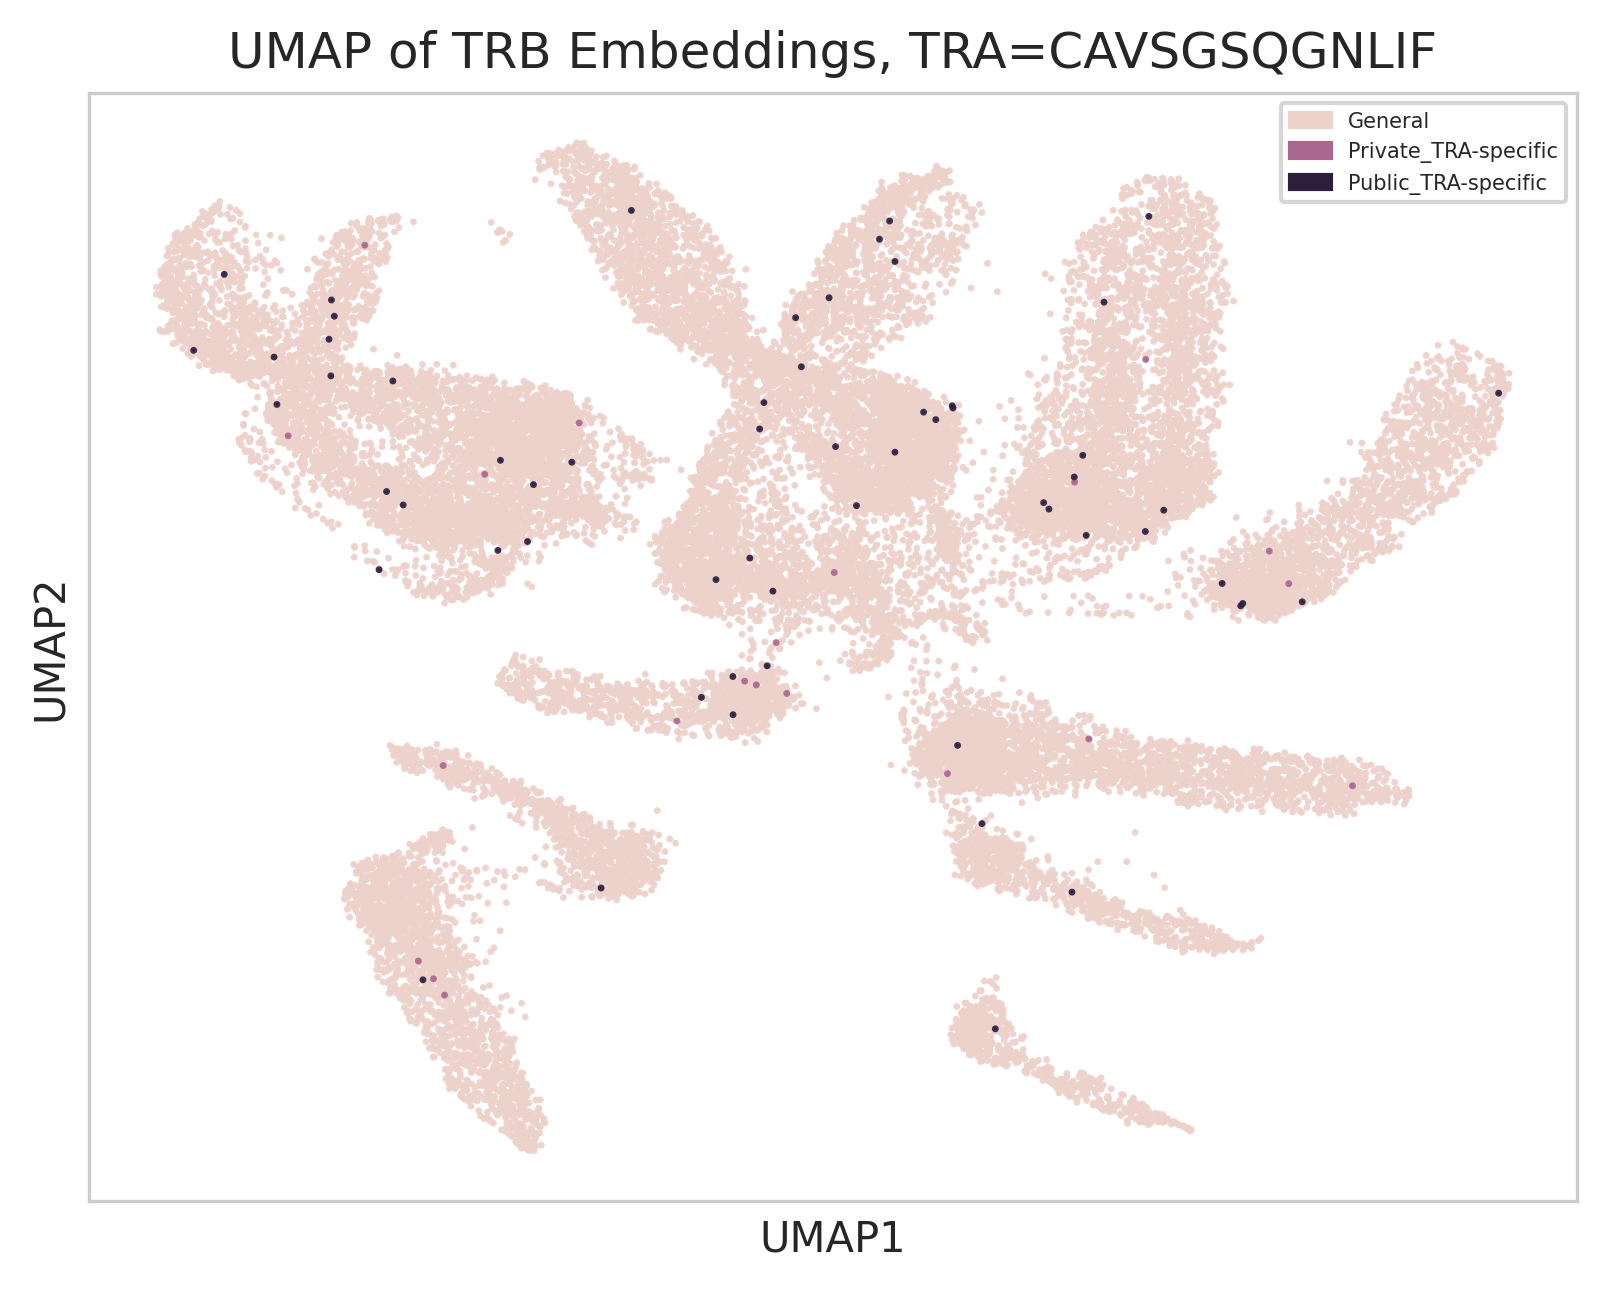

In [66]:
# Plot embeddings
importlib.reload(plot_utils)
embed_wrap.sequences_df.sort_values(by='Label', inplace=True,  ascending=True)
embed_wrap.plot_embedding(
    color_embed='Label',
    color_map=color_map,
    title="UMAP of TRB Embeddings, TRA=" + tra_2plot,
    legend_size=5,
    plot_pdf_path=os.path.join(PLOT_DIR, "umap_chain_single_cell.pdf"),
    n_comps=50
)

#### Analyze Publicness

In [244]:
trbs_of_CAVMDSNYQLIW_pubpriv = pd.read_csv("./CDR3_data/TRA_specific/trbs_of_CAVMDSNYQLIW_pubpriv.csv")
counts = collections.Counter(trbs_of_CAVMDSNYQLIW_pubpriv.Public_Private_Label)
total_count = sum(counts.values())
percentages = {item: count/total_count*100 for item, count in counts.items()}
percentages

{1: 66.37931034482759, 0: 33.62068965517241}

In [18]:
trbs_of_CAVSGSQGNLIF_pubpriv = pd.read_csv(
    "./CDR3_data/TRA_specific/trbs_of_CAVSGSQGNLIF_pubpriv.csv")
counts = collections.Counter(trbs_of_CAVSGSQGNLIF_pubpriv.Public_Private_Label)
total_count = sum(counts.values())
percentages = {item: count / total_count * 100 for item, count in counts.items()}
percentages

{1: 79.1907514450867, 0: 20.809248554913296}

In [166]:
import plotly.graph_objs as go
import umap

# Apply UMAP to obtain a lower-dimensional projection of the embeddings
umap_embeddings = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='cosine').fit_transform(embed_wrap.embeddings)

label_colors = {'TRA-specific': 'red', 'general':'gray' }
color_list = [label_colors[label] for label in df_for_embedding['Label']]
# Create a scatter plot of the UMAP projection using Plotly
fig = go.Figure(data=go.Scatter(x=umap_embeddings[:,0],
                                y=umap_embeddings[:,1],
                                mode='markers',
                                marker=dict(color=color_list, size=4),
                                text=df_for_embedding["Label"]))

# Add hover information to display sequence information when hovering over points
fig.update_traces(hoverinfo='text')

# Show the plot
fig.show()

#### Prediction of TRA match of TRB

In [4]:
# read trb to tra mapping data (100k from single cell data)
trb_to_tra_df = pd.read_csv("./CDR3_data/trb_to_tra_mapping_100k_scData.csv")
tra_to_trb_df = pd.read_csv("./CDR3_data/tra_to_trb_mapping_100k_scData.csv")

In [5]:
# extract unique TRB/TRA sequences to list
trb_unique_list = trb_to_tra_df.TRB_unique
tra_unique_list = tra_to_trb_df.TRA_unique
trb_unique_list=trb_unique_list.to_list()
tra_unique_list=tra_unique_list.to_list()

In [7]:
import pandas as pd
from tqdm import tqdm

def calc_top_tra_scores(trb_seqs, tra_seqs, model, tokenizer, device):
    scores = []
    for trb_seq in tqdm(trb_seqs, desc="TRB"):
        trb_scores = []
        for tra_seq in tqdm(tra_seqs, desc="TRA"):
            # Calculate perplexity of TRB|TRA sequence
            input_seq = f"{trb_seq}|{tra_seq}"
            ppl = cs.calc_pseudo_perplexity(model, tokenizer, input_seq, device)
            trb_scores.append((tra_seq, ppl))

        # Sort TRA sequences by perplexity score
        trb_scores.sort(key=lambda x: x[1])
        top_tra_scores = trb_scores[:20]

        # Extract top TRA sequences and scores
        top_tra_seqs = [tra_seq for tra_seq, score in top_tra_scores]
        top_scores = [score for tra_seq, score in top_tra_scores]

        scores.append((trb_seq, top_tra_seqs, top_scores))

    # Convert scores to pandas DataFrame
    df = pd.DataFrame(scores, columns=["TRB", "TRA_Seqs", "Scores"])

    return df

In [ ]:
my_model, my_tok = model_utils.get_model_tokenizer(model_dir=SC_TRANSFORMER , method="mean", device=DEVICE, max_len=120)
df = calc_top_tra_scores(trb_unique_list[3:4], tra_unique_list, my_model, my_tok, DEVICE)

In [ ]:
pred_TRA_seqs = df.TRA_Seqs.to_list()
pred_TRA_seqs

In [ ]:
trb_unique_list[3:4][0]

In [ ]:
real_TRA_seqs = trb_to_tra_df[trb_to_tra_df.TRB_unique==trb_unique_list[3:4][0]].TRA.to_list()
real_TRA_seqs